In [24]:
import spacy
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer

In [2]:
# Settings
ROOTC = "../corpus/"   # root files corpus
ROOTP = "../pickles/"  # root files pickles

**Preprocesamiento del corpus**

In [3]:
def preProcessing(ncorpus):
    """
    input: corpus name
    output: tokenizer doc, without stop-words and DIGITO word
    """
    corpus = ROOTC + ncorpus
    nlp = spacy.load('es')
    
    # See https://spacy.io/usage/spacy-101#pipelines
    # disable pipeline from spacy
    pipe = ["ner"]

    tokenizer_doc = []
    with open(corpus) as fd:
        for document in tqdm(fd.readlines()):
            document = document.strip()
            nlp.max_length = max(len(document), nlp.max_length)
            
            # nlp create doc object(token sequence)
            tokens = [ token for token in nlp(document, disable=pipe) 
                       if not ((token.is_stop) or (token.text == 'DIGITO'))
                     ]
            
            # delete documents long less than 8
            if len(tokens) > 8:
                tokenizer_doc.append(tokens)
    return tokenizer_doc

**Diccionario de caracterisiticas**

In [4]:
# See https://spacy.io/api/token
def featuresDic(tokenizer):
    to_vector = []
    words = []
    for document in tokenizer:
        has_prev = False
        for token in document:
            features = {}
            features['word'] = token.text
            features['pos'] = token.pos_
            features['lemma'] = token.lemma_                        
            features['is_lower'] = token.is_lower
            
            # dependence tripla: TOKEN has a DEP_ relationship with HEAD
            features['dt'] = '_D_' + token.dep_ + '_H_' + token.head.orth_
            if has_prev:
              features['pre_word'] = token.nbor(-1).orth_
            try:
              features['pos_word'] = token.nbor().orth_
            except IndexError:
              pass
            has_prev = True
            to_vector.append(features)
            words.append(token.text)
    return to_vector, words

**Vectorizado de las caracteristicas**

In [5]:
# See https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html
def vectorizer(features):
    v = DictVectorizer()
    X = v.fit_transform(features)
    return X

**Reduccion de dimensionalidad**

In [6]:
# See https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD
def reductionDim(v, n, n_iter):
    svd = TruncatedSVD(n_components=n, n_iter=n_iter)
    Y = svd.fit_transform(v)
    return Y

**Clustering**

In [16]:
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
def clustering(v, n_clusters, n_iter):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=n_iter, random_state=256)
    kmeans.fit(v)
    v_labels = kmeans.predict(v)
    return kmeans, v_labels

**Elbow metodo**

In [42]:
def elbowMethod(ka, kb, v_rd):
    Sum_of_squared_distances = []
    K = range(ka, kb, 10)
    for k in tqdm(K):
        km = KMeans(n_clusters=k)
        km = km.fit(v_rd)
        Sum_of_squared_distances.append(km.inertia_)
    
    plt.plot(K, Sum_of_squared_distances, 'ro-', markersize=8, lw=2)
    plt.xlabel('number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [48]:
def cluster_save(n_clusters, clusters):
    path = ROOTP + 'cluster' + str(n_clusters) + '.pkl'
    with open(path, "wb") as fd:
        pickle.dump(clusters, fd)

**========================================================================================================================**

In [8]:
# load corpus and reprocessing
tokenizers = preProcessing("xaa")

100%|██████████| 7277/7277 [00:48<00:00, 150.31it/s]


In [12]:
# selection features for vectorize, only 200 docs
to_vectorize, words = featuresDic(tokenizers[:200])
# vectorize features
vectors = vectorizer(to_vectorize)
# dimensionality reduction
vectors_dr = reductionDim(vectors, 6, 20)

100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


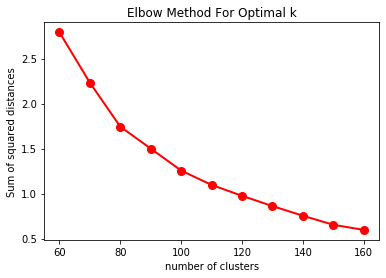

In [45]:
elbowMethod(60, 170, vectors_dr)

In [22]:
# clustering
kmeans, labels = clustering(vectors_dr, 82, 250)
# associate each word with its label
c = list(zip(labels, words))

clusters = defaultdict(set)
for idc, word in c:
    clusters[idc].add(word)

# show clusters
clusters

defaultdict(set,
            {15: {'actuaciones',
              'animadora',
              'artículo',
              'bate',
              'cabo',
              'canciones',
              'cargas',
              'colabora',
              'convertirse',
              'células',
              'datos',
              'director',
              'empleado',
              'encuentro',
              'exclusión',
              'forma',
              'franceses',
              'fuerza',
              'inglés',
              'jóvenes',
              'letras',
              'lugares',
              'motivo',
              'nombre',
              'oro',
              'orígenes',
              'partidos',
              'país',
              'pop',
              'presencia',
              'redactor',
              'resolución',
              'salón',
              'teatro',
              'álbum'},
             1: {'anillo',
              'aro',
              'asociación',
              'aspecto',
    

In [49]:
# save cluster
cluster_save(82, clusters)